In [1]:
library(latex2exp)


Warning message:
"package 'latex2exp' was built under R version 3.6.3"

In [2]:
library(igraph)
library(ggplot2)
library(pracma)

Warning message:
"package 'igraph' was built under R version 3.6.3"
Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

Warning message:
"package 'ggplot2' was built under R version 3.6.2"Warning message:
"package 'pracma' was built under R version 3.6.3"

# Generating Random Networks

## 1. Create random networks using the Erdos-Renyi (ER) model.

### (a) Create undirected random networks with n = 1000 nodes, and the probability p for drawing an edge between two arbitrary vertices 0.003, 0.004, 0.01, 0.05, and 0.1. Plot the degree distributions. What distribution is observed? Explain why. Also, report the mean and variance of the degree distributions and compare them to the theoretical values.

In [3]:
rm(list=ls())

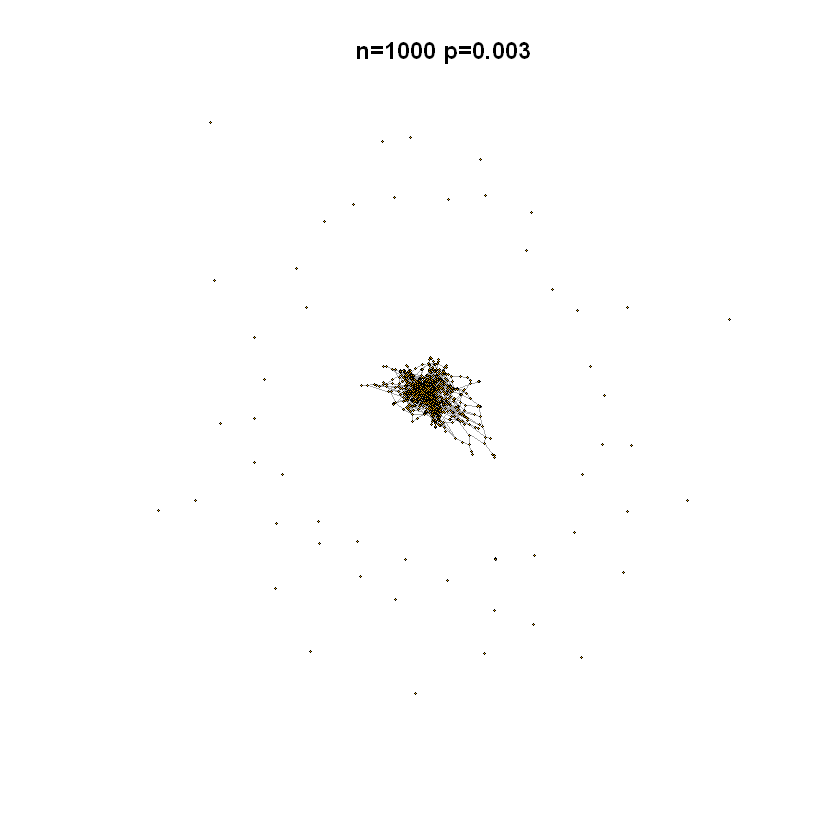

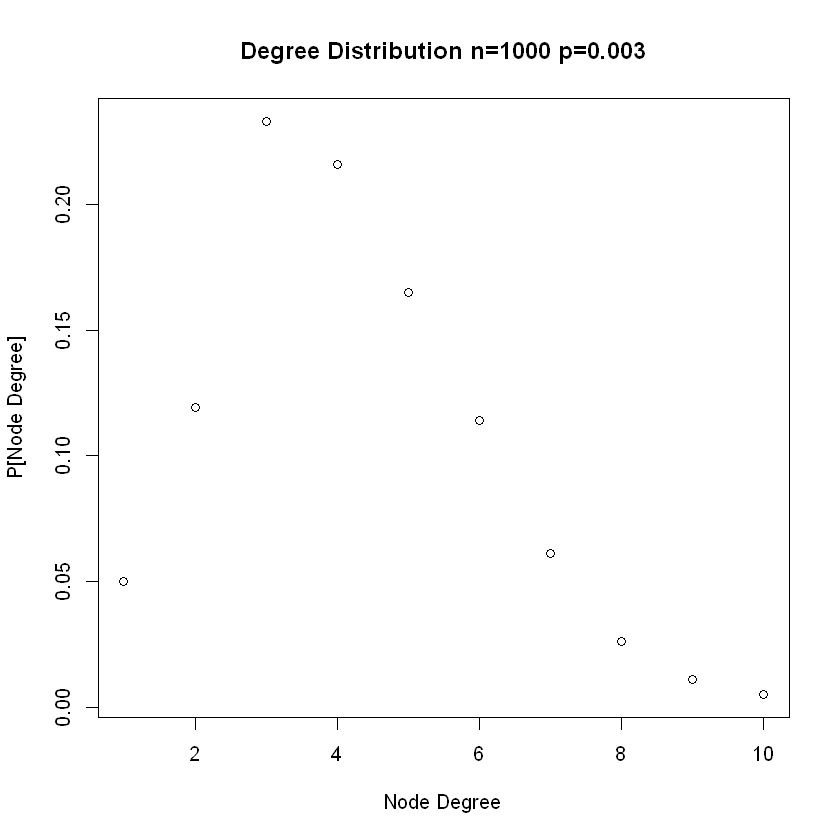

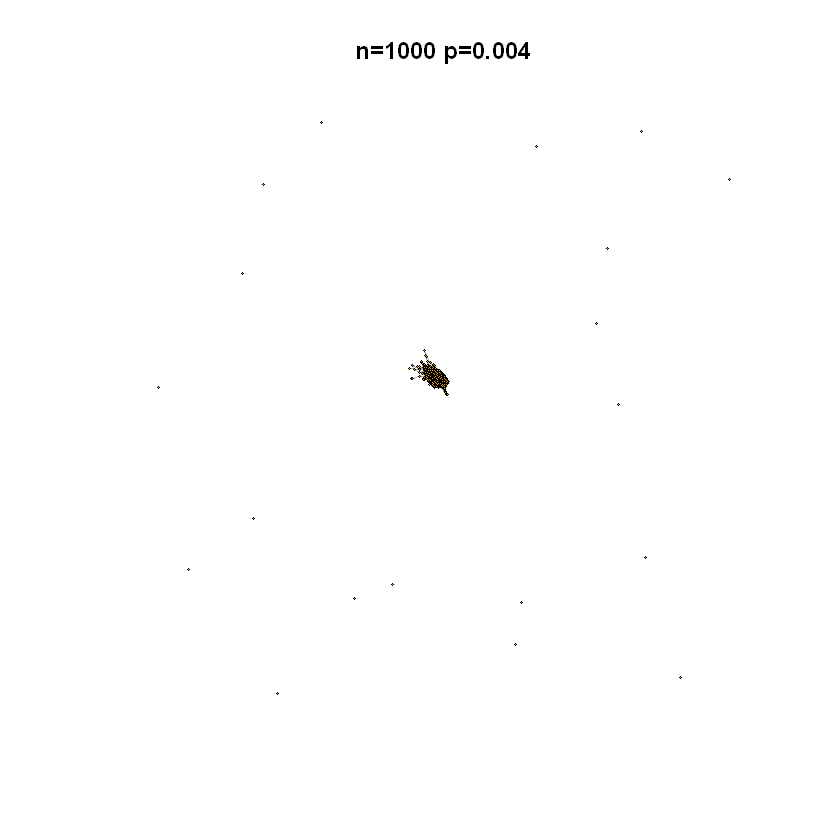

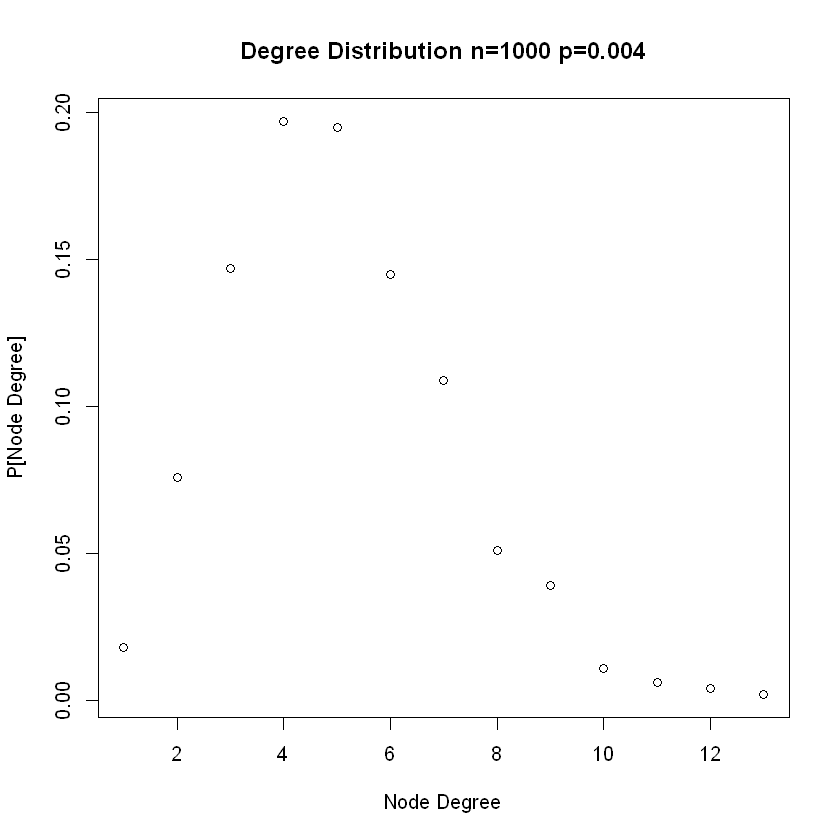

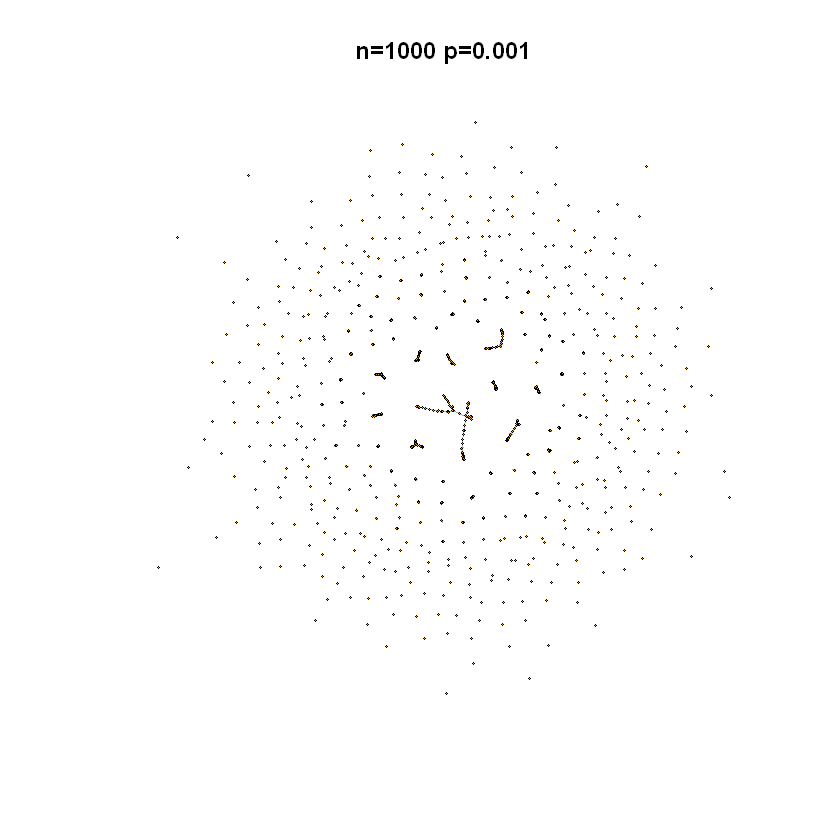

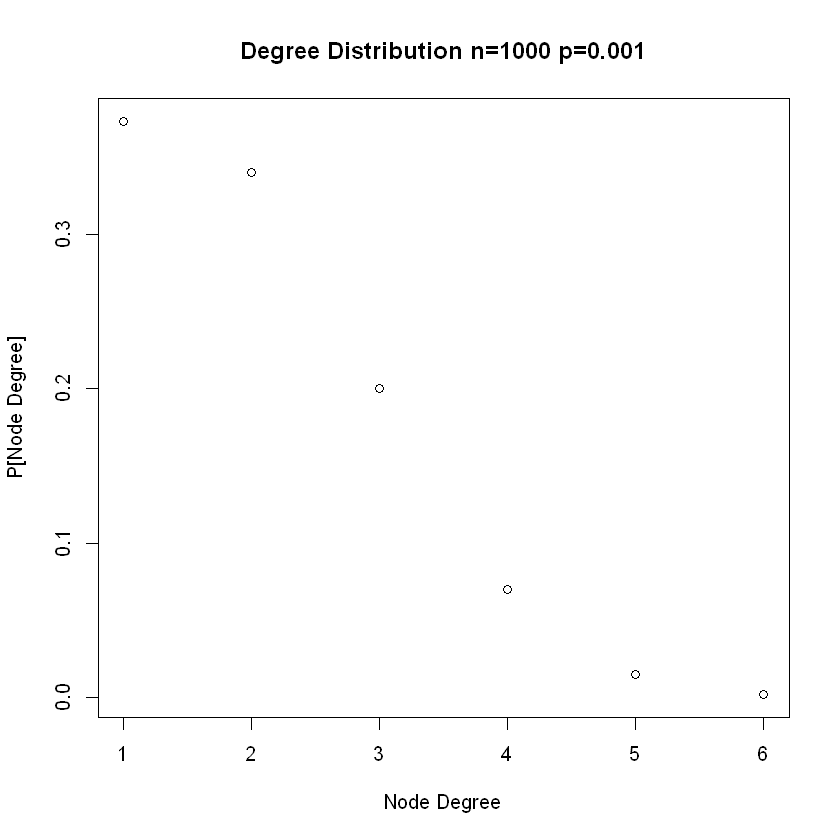

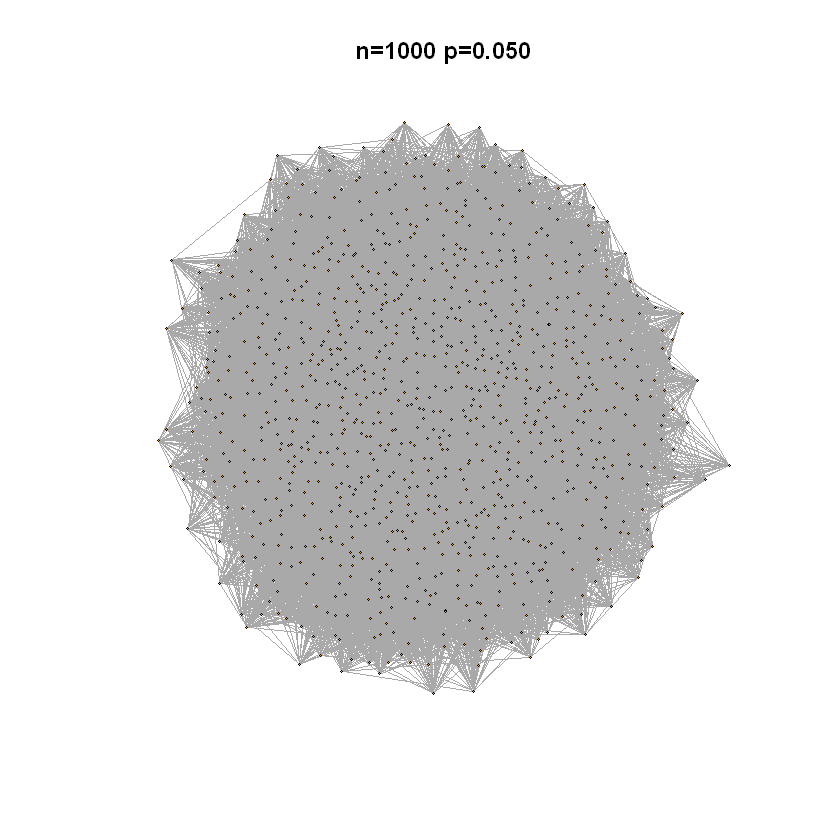

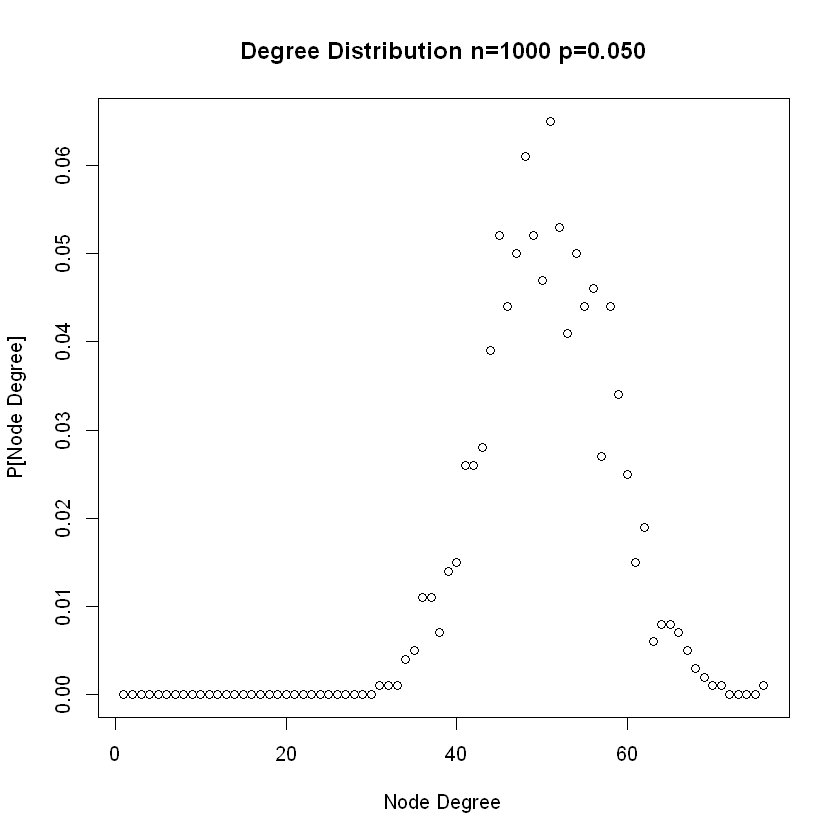

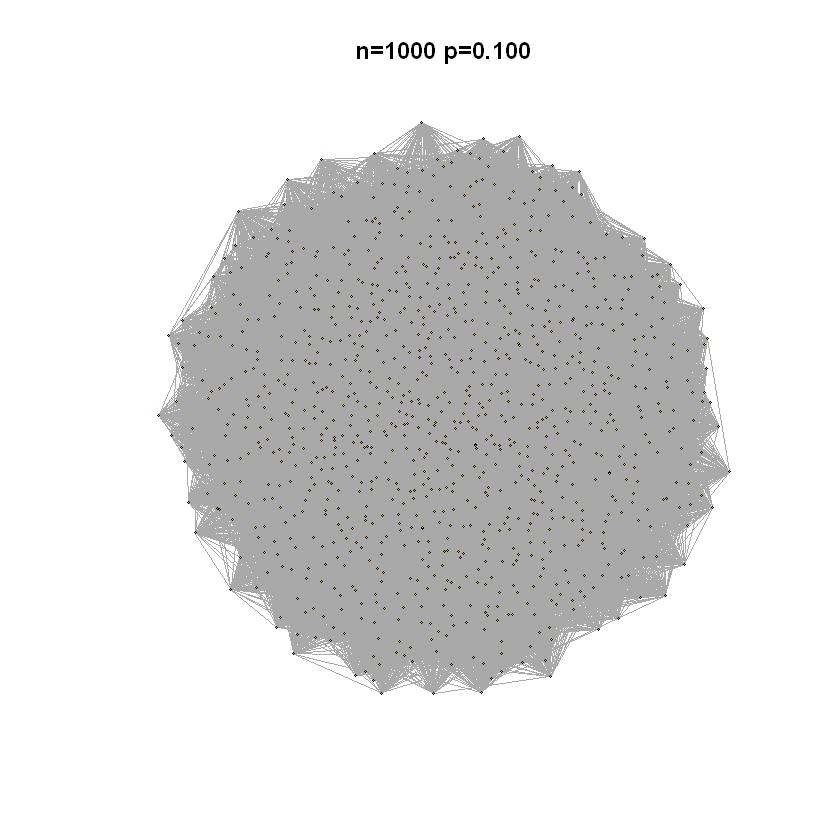

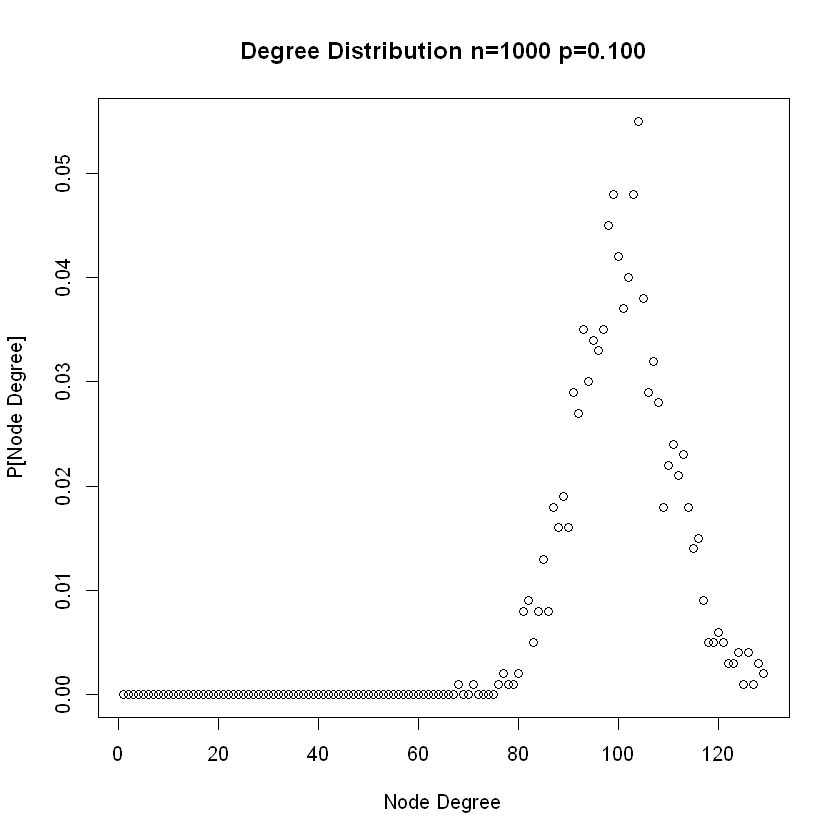

In [4]:
N <- 1000; P <- c(0.003,0.004,0.001,0.05,0.1)

cnames <- c("p=0.003","p=0.004","p=0.001","p=0.05","p=0.1")
rnames <- c("Measured Mean","Theoretical Mean","Measured Var","Theoretical Variance")
moment_matrix = matrix(nrow=4,ncol=length(P),dimnames=list(rnames,cnames))
G = list()

#dev.off()
#par(mfrow=c(length(P),2))
for (i in seq_along(P)){
    g <- sample_gnp(N,P[i])
    G[[i]] = g

    #options(repr.plot.width=10, repr.plot.height=10)
    plot(g,vertex.size=1,vertex.label=NA,margin=c(0,0,0,0))
    title(sprintf("n=%.0f p=%.3f",N,P[i]))
    
    degree_dist = degree.distribution(g)
    degrees = degree(g)
    #options(repr.plot.width=5, repr.plot.height=5)
    plot(degree.distribution(g),main=sprintf("Degree Distribution n=%.0f p=%.3f",N,P[i]),
         xlab="Node Degree",ylab="P[Node Degree]")

    measured_mean <- c(mean(degrees),N*P[i],var(degrees),N*P[i]*(1-P[i]));
    moment_matrix[,i] = measured_mean;
}

In [5]:
print(moment_matrix)

                      p=0.003  p=0.004  p=0.001   p=0.05     p=0.1
Measured Mean        3.144000 4.016000 1.020000 49.63600  99.99400
Theoretical Mean     3.000000 4.000000 1.000000 50.00000 100.00000
Measured Var         3.182446 4.239984 1.020621 49.25676  91.07504
Theoretical Variance 2.991000 3.984000 0.999000 47.50000  90.00000


### (b) For each p and n = 1000, answer the following questions: Are all random realizations of the ER network connected? Numerically estimate the probability that a generated network is connected. For one instance of the networks with that p, and the giant connected component (GCC) if not connected. What is the diameter of the GCC?

In [6]:
rm(list=ls())

In [7]:
get_giant = function(g){
    cl = clusters(g)
    largest_cluster = which.max(cl$csize)
    subset_vertices = V(g)[cl$membership==largest_cluster]
    giant_component = induced_subgraph(g,subset_vertices)
    return(giant_component)
}

In [8]:
N <- 1000; P <- c(0.003,0.004,0.001,0.05,0.1); N_trials = 10000;

cnames <- c("p=0.003","p=0.004","p=0.001","p=0.05","p=0.1")
rnames <- c("p[connected]","Diameter")
connected_matrix <- matrix(nrow=2,ncol=length(P),dimnames=list(rnames,cnames))
trial_matrix <- matrix(nrow=N_trials,ncol=length(P)); trial_matrix[2,] = -1

for (i in seq_along(P)){
    disconnected_check <- TRUE
    for (j in seq(from=1,to=N_trials)){
        g <- sample_gnp(N,P[i])
        connected <- is.connected(g)
        trial_matrix[j,i] = connected
        }
    
        if (!connected & disconnected_check) {
            giant <- get_giant(g)
            connected_matrix[2,i] <- diameter(giant,directed=FALSE)
            disconnected_check <- FALSE
            next
        }
    connected_matrix[2,i] <- diameter(g,directed=FALSE)
}
connected_matrix[1,] <- colMeans(trial_matrix)

In [9]:
connected_matrix[1,] = colMeans(trial_matrix)

In [10]:
connected_matrix

,p=0.003,p=0.004,p=0.001,p=0.05,p=0.1
p[connected],0,0,0,1,1
Diameter,16,11,33,3,3


### (c) It turns out that the normalized GCC size (i.e., the size of the GCC as a fraction of the total network size) is a highly nonlinear function of p, with interesting properties occurring for values where p = O( $\frac{1}{n}$ ) and p = O( $\frac{ln(n)}{n}$ ). For n = 1000, sweep over values of p from 0 to a pmax that makes the network almost surely connected and create 100 random networks for each p. pmax should be roughly determined by yourself. Then scatter plot the normalized GCC sizes vs p. Plot a line of the average normalized GCC sizes for each p along with the scatter plot.

In [11]:
rm(list=ls())

In [12]:
N = 1000; p_max = log(N)/N; p_emergence = 1/N; P = linspace(0,p_max*1.1,100)
N_trials = 100
trial_matrix = matrix(nrow=length(P),ncol=N_trials)

In [13]:
print(sprintf("Almost always connected @ p=%.5f",p_max))
print(sprintf("Emergence of GCC @ p=%.5f",p_emergence))

[1] "Almost always connected @ p=0.00691"
[1] "Emergence of GCC @ p=0.00100"


In [14]:
for (i in seq_along(P)){
    for (j in seq_len(N_trials)){
         g <- sample_gnp(N,P[i])
         cl = clusters(g); gcc_size = max(cl$csize)
         trial_matrix[i,j] = gcc_size/N
    }
}

In [15]:
gcc_sizes = as.vector(Reshape(t(trial_matrix),1,length(P)*N_trials)); P_plot = rep(P,each=N_trials); 

gcc_avg_df = data.frame(GCC_Avg = rowMeans(trial_matrix),p=P)
gcc_df = data.frame(gcc_sizes,P_plot)

#### (i) Empirically estimate the value of p where a giant connected component starts to emerge (define your criterion of emergence")? Do they match with theoretical values mentioned or derived in lectures?

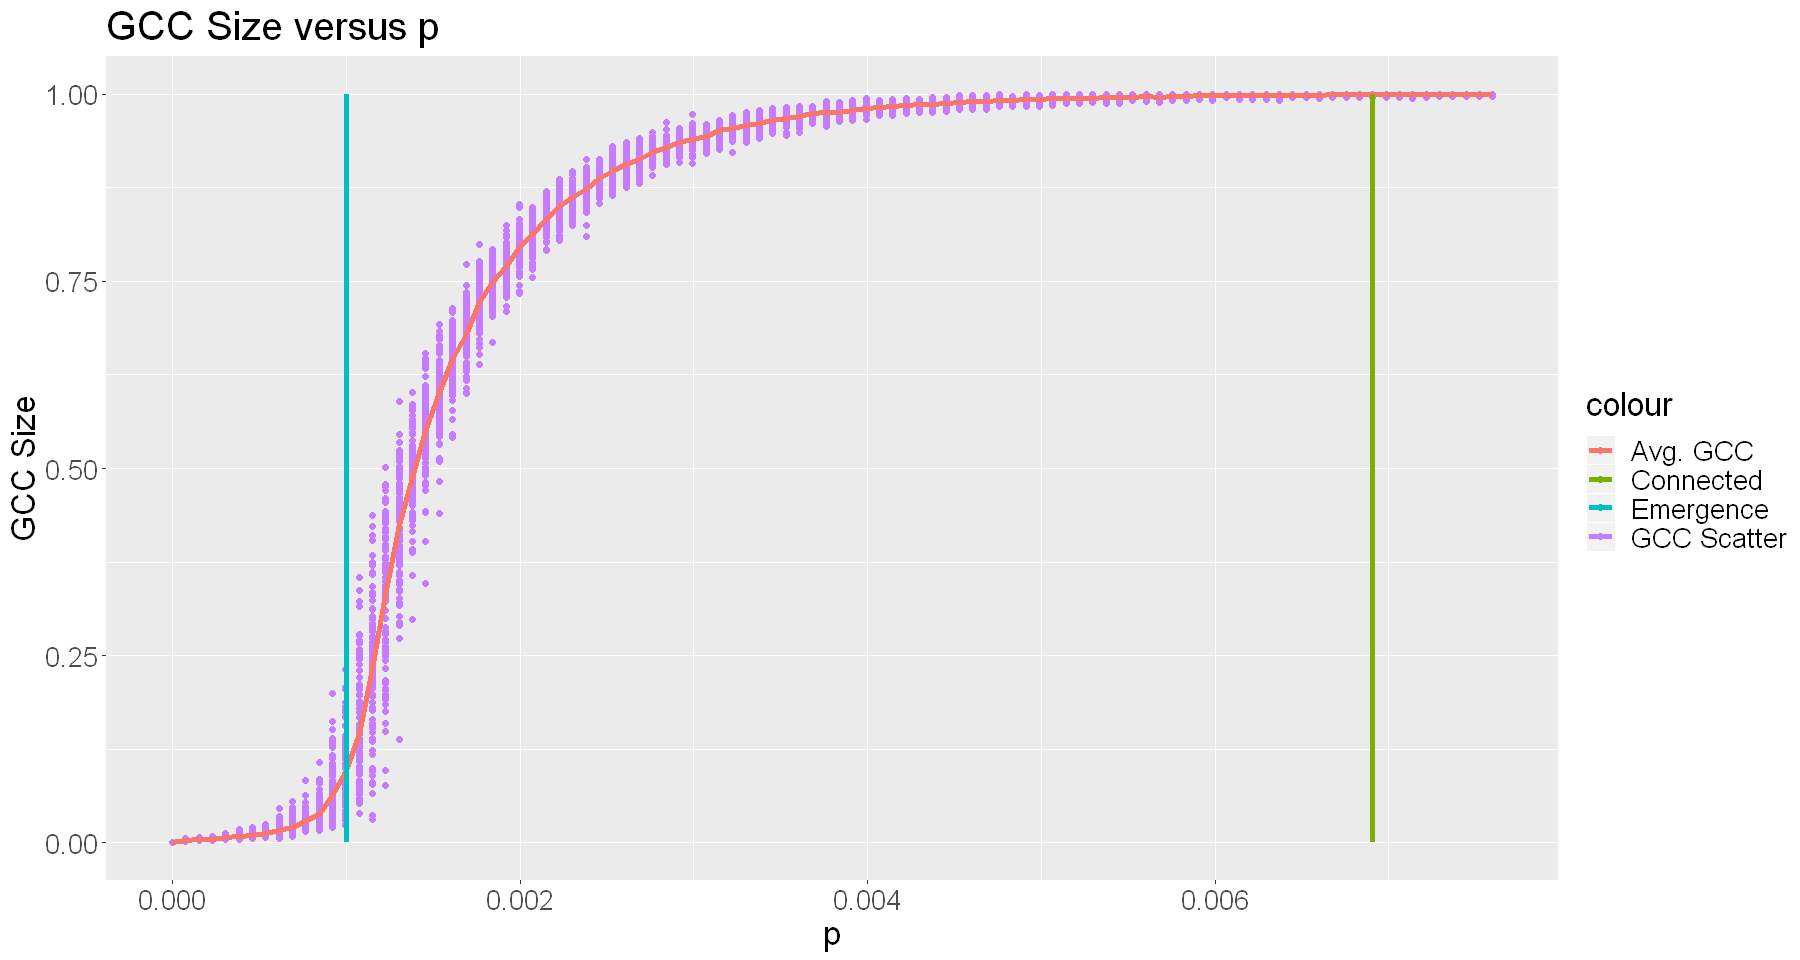

In [16]:
scatterplot <- ggplot() +
geom_point(aes(x=P_plot,y=gcc_sizes,colour='GCC Scatter'),data=gcc_df) +
geom_line(aes(x=p,y=GCC_Avg,colour="Avg. GCC"),size=1.5,data=gcc_avg_df) + 
geom_line(aes(x=c(p_emergence,p_emergence),y=c(0,max(gcc_sizes)),colour="Emergence"),size=1.5) + 
geom_line(aes(x=c(p_max,p_max),y=c(0,max(gcc_sizes)),colour="Connected"),size=1.5) + 
ylab("GCC Size") + xlab("p") + labs(title="GCC Size versus p") +
theme(text = element_text(size=20))

options(repr.plot.width=15, repr.plot.height=8)

plot(scatterplot)

In [17]:
sharp_increase <- which.max(diff(gcc_avg_df$GCC_Avg))
P[sharp_increase]

[1] 0.001151293

#### Empirically estimate the value of p where the giant connected component takes up over 99% of the nodes in almost every experiment.

In [18]:
takeover <- which.max(gcc_avg_df > 0.990)
P[takeover]

[1] 0.004681923

### (d)

#### i. Defne the average degree of nodes c = n * p = 0.5. Sweep over the number of nodes, n, ranging from 100 to 10000. Plot the expected size of the GCC of ER networks with n nodes and edge-formation probabilities p = c=n, as a function of n. What trend is observed?

In [30]:
rm(list=ls())

In [31]:
N <- linspace(100,10000,50); c <- 0.5; N_trials <- 1000
gcc_expected <- matrix(ncol=length(N),nrow=1,dimnames=list(list(),paste("n=",N)))
for (i in seq_along(N)){
    p <- c/N[i]
    gcc_trials <- vector(mode='double',length=N_trials)
    for (j in seq_len(N_trials)){
        g <- sample_gnp(N[i],p)
        cl = clusters(g); gcc_size = max(cl$csize)
        gcc_trials[j] <- gcc_size
    }
    gcc_expected[i] = mean(gcc_trials)
}

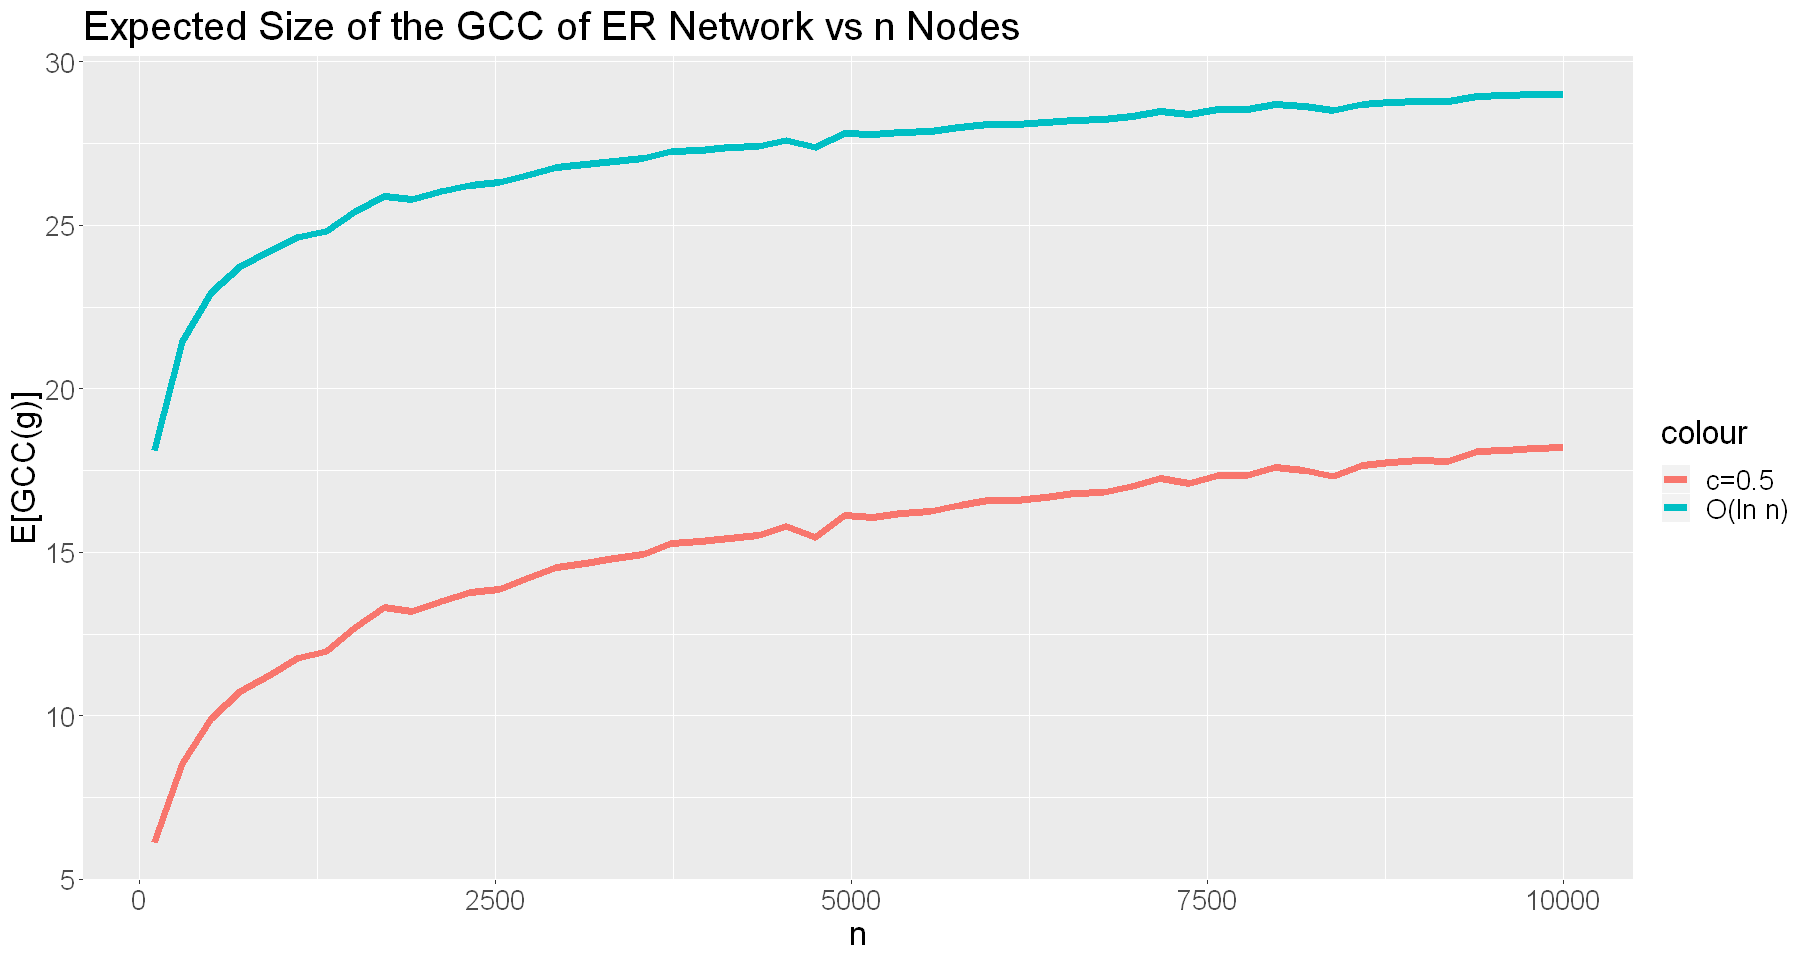

In [21]:
ggplot() + geom_line(aes(x=N,y=as.vector(gcc_expected),colour="c=0.5"),size=2) + 
geom_line(aes(x=N,y=10*log(as.vector(gcc_expected)),colour="O(ln n)"),size=2) + 
labs(x="n",y="E[GCC(g)]",title="Expected Size of the GCC of ER Network vs n Nodes") + 
theme(text = element_text(size=20))

#### ii. Repeat the same for c = 1.

In [22]:
N <- linspace(100,10000,50); c <- 1; N_trials <- 1000
gcc_expected <- matrix(ncol=length(N),nrow=1,dimnames=list(list(),paste("n=",N)))
for (i in seq_along(N)){
    p <- c/N[i]
    gcc_trials <- vector(mode='double',length=N_trials)
    for (j in seq_len(N_trials)){
        g <- sample_gnp(N[i],p)
        cl = clusters(g); gcc_size = max(cl$csize)
        gcc_trials[j] <- gcc_size
    }
    gcc_expected[i] = mean(gcc_trials)
}

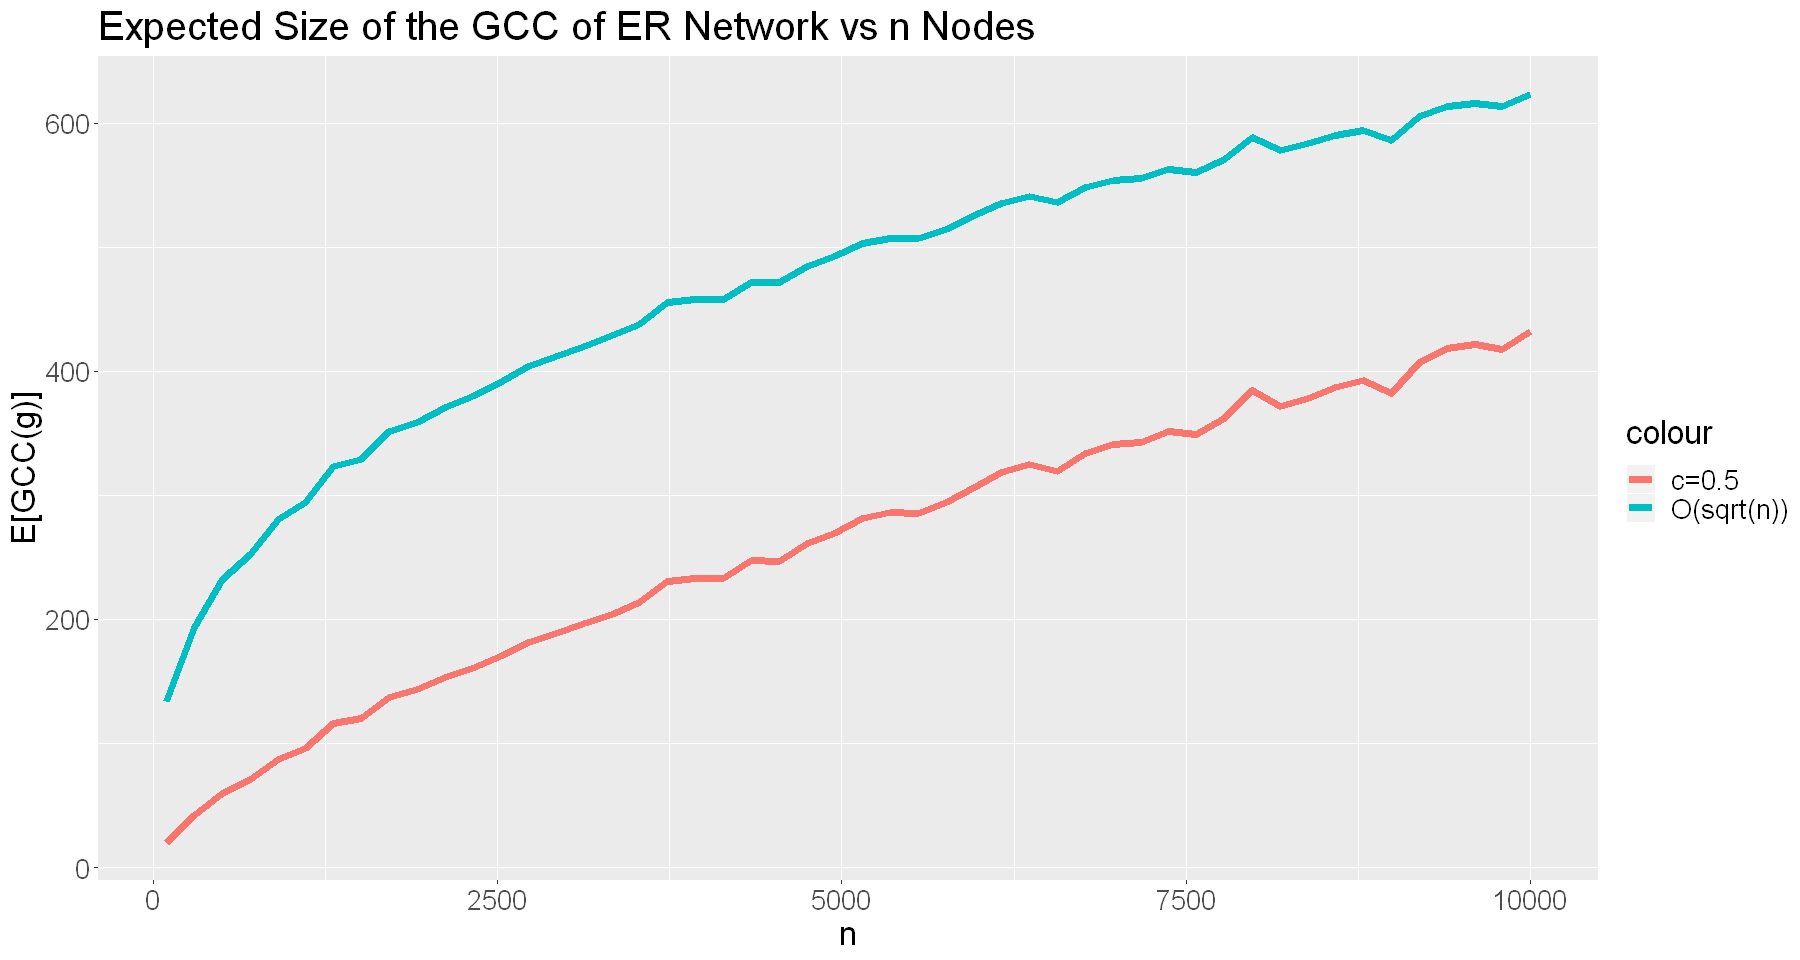

In [23]:
ggplot() + geom_line(aes(x=N,y=as.vector(gcc_expected),colour="c=0.5"),size=2) + 
geom_line(aes(x=N,y=30*sqrt(as.vector(gcc_expected)),colour="O(sqrt(n))"),size=2) + 
labs(x="n",y="E[GCC(g)]",title="Expected Size of the GCC of ER Network vs n Nodes") + 
theme(text = element_text(size=20))

#### iii. Repeat the same for values of c = 1:1; 1:2; 1:3, and show the results for these three values in a single plot.

In [24]:
N <- linspace(100,10000,50); C <- c(1.1,1.2,1.3); N_trials <- 1000
gcc_matrix <- matrix(nrow=length(C),ncol=length(N))
for (k in seq_len(length(C))){
    gcc_expected <- matrix(ncol=length(N),nrow=1,dimnames=list(list(),paste("n=",N)))
    for (i in seq_along(N)){
        p <- c[k]/N[i]
        gcc_trials <- vector(mode='double',length=N_trials)
        for (j in seq_len(N_trials)){
            g <- sample_gnp(N[i],p)
            cl = clusters(g); gcc_size = max(cl$csize)
            gcc_trials[j] <- gcc_size
        }
        gcc_expected[i] = mean(gcc_trials)
    }
    gcc_matrix[k,] = as.vector(gcc_expected)
}

In [28]:
gcc_matrix

19.583,40.875,56.41,73.598,85.659,98.809,114.142,122.722,135.304,142.324,...,382.615,389.74,402.992,398.097,395.691,424.57,407.392,424.948,427.104,446.197
1.000,1.000,1.00,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.00,1.000,1.000,1.000,1.00,1.000,1.000,1.000,1.000
1.000,1.000,1.00,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.00,1.000,1.000,1.000,1.00,1.000,1.000,1.000,1.000


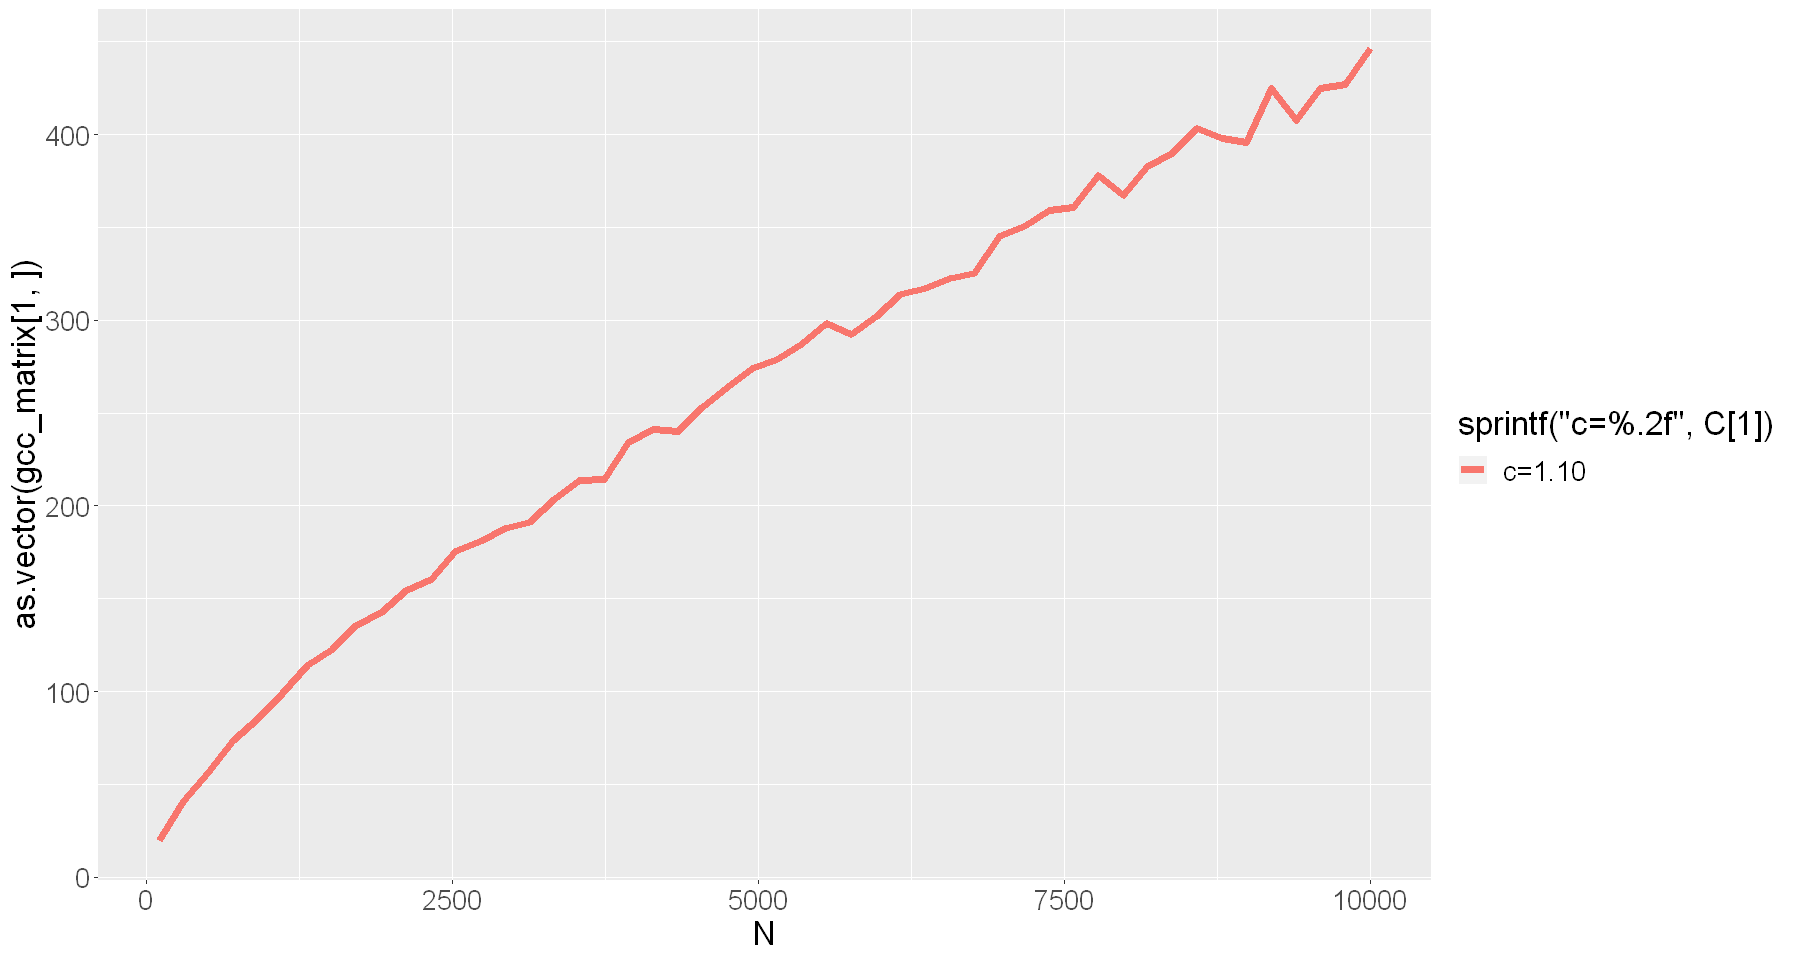

In [27]:
viz <- ggplot() +  geom_line(aes(x=N,y=as.vector(gcc_matrix[1,]),colour=sprintf("c=%.2f",C[1])),size=2) + 
#geom_line(aes(x=N,y=as.vector(gcc_matrix[2,]),colour=sprintf("c=%.2f",C[2])),size=2) +  
#geom_line(aes(x=N,y=as.vector(gcc_matrix[3,]),colour=sprintf("c=%.2f",C[3])),size=2) +  
#labs(x="n",y="E[GCC(g)]",title="Expected Size of the GCC of ER Network vs n Nodes") +
theme(text = element_text(size=20))
plot(viz)

#### iv. What is the relation between the expected GCC size and n in each case?

## 2. Create networks using the preferential attachment model.

### (a) Create an undirected network with n = 1000 nodes, with preferential attachment model, where each new node attaches to m = 1 old nodes. Is such a network always connected?

In [94]:
rm(list=ls())

In [95]:
N = 1000; M = 1;
g_1000 <- sample_pa(n=N,m=M,directed=FALSE)

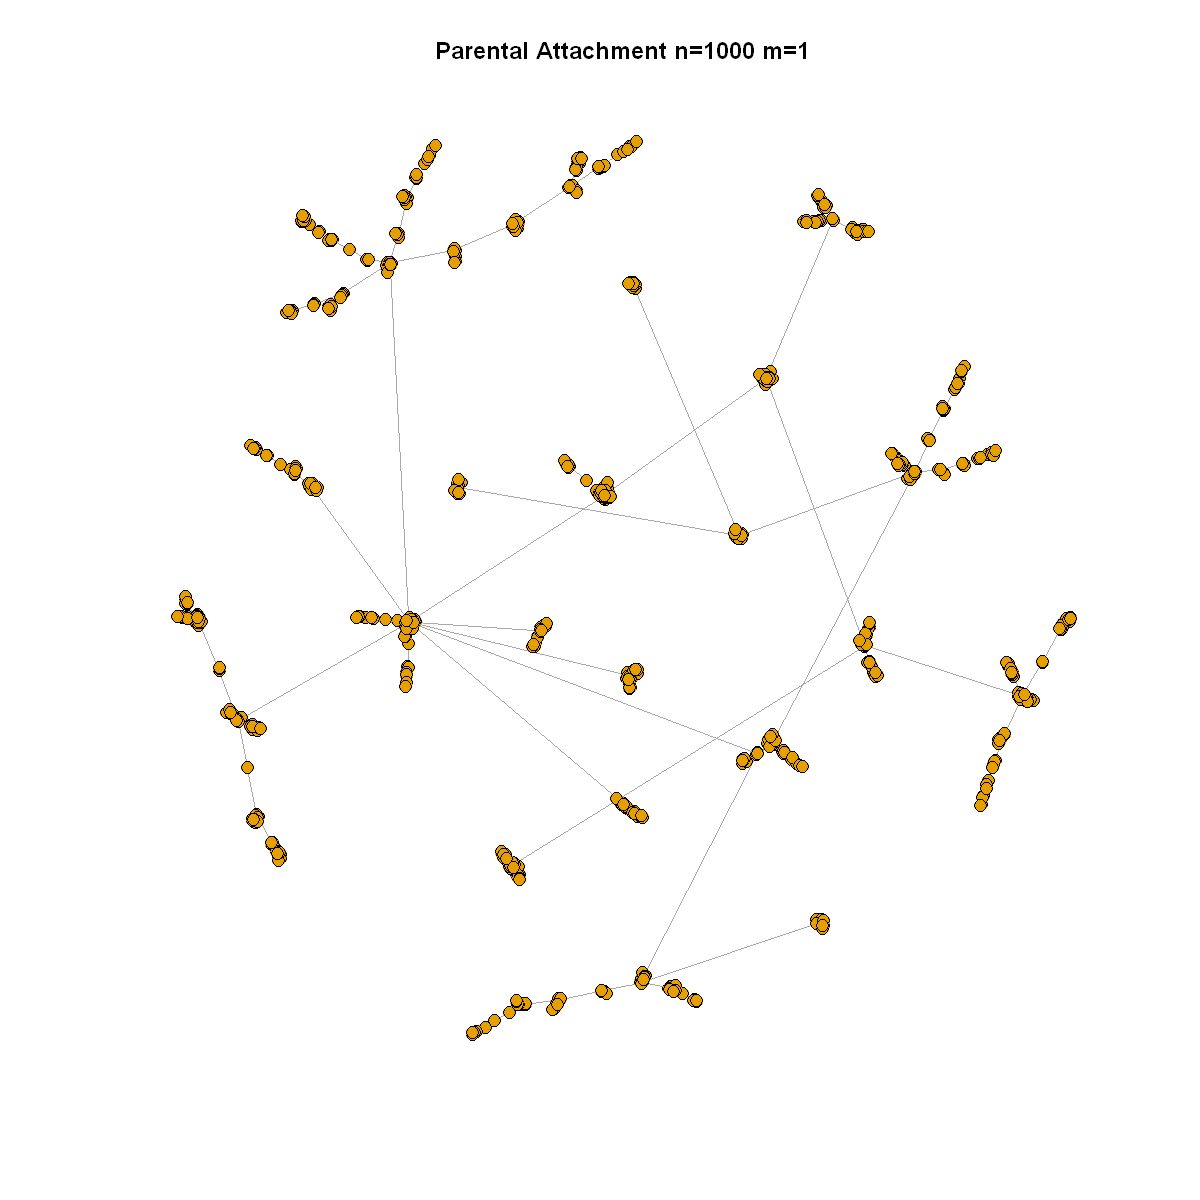

In [96]:
options(repr.plot.width=10, repr.plot.height=10)
plot(g_1000,vertex.size=3,vertex.label=NA,margin=c(0,0,0,0),arrow.size=0)
title(sprintf("Parental Attachment n=%.0f m=%.0f",N,M))

### (b) Use fast greedy method to nd the community structure. Measure modularity.

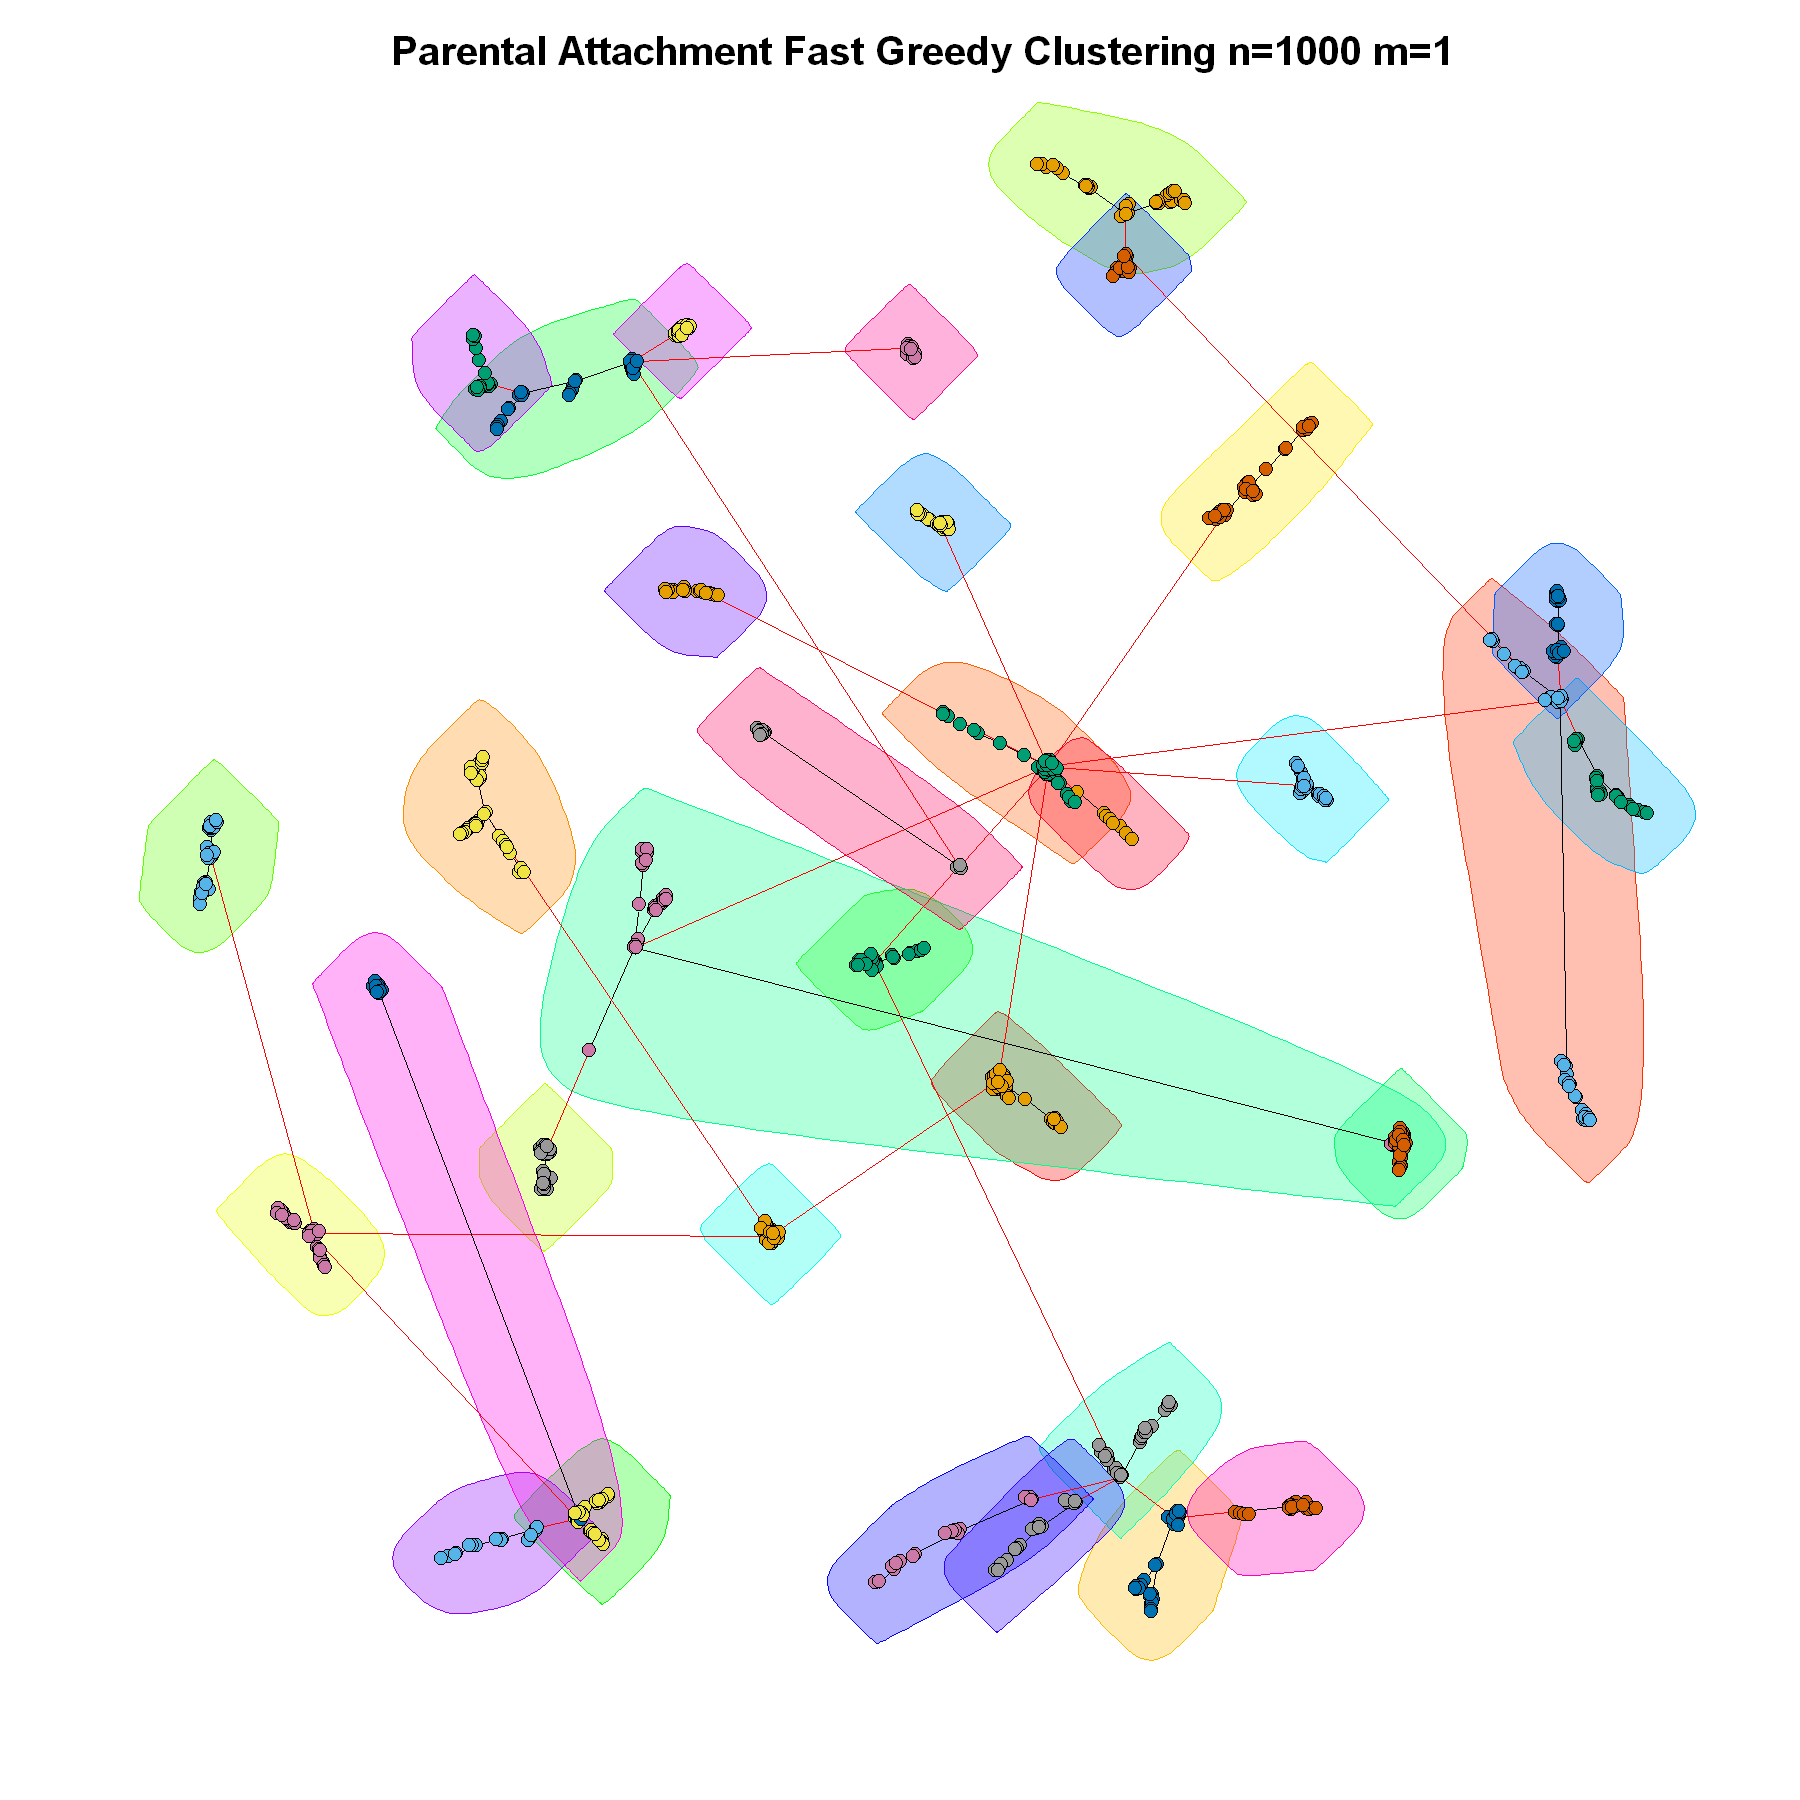

In [106]:
cluster_fg_1000= cluster_fast_greedy(g_1000)
options(repr.plot.width=15, repr.plot.height=15)
plot(cluster_fg_1000, g_1000, vertex.label=NA,vertex.size=2,margin=c(0,0,0,0))
title(sprintf("Parental Attachment Fast Greedy Clustering n=%.0f m=%.0f",N,M),cex.main=2)

In [91]:
print(sprintf("The modularity of the graph is %.4f",modularity(cluster_fg_1000)))

[1] "The modularity of the graph is 0.9351"


### (c) Try to generate a larger network with 10000 nodes using the same model. Compute modularity. How is it compared to the smaller network's modularity?

In [110]:
N = 10000; M = 1;
g_10000 <- sample_pa(n=N,m=M,directed=FALSE)

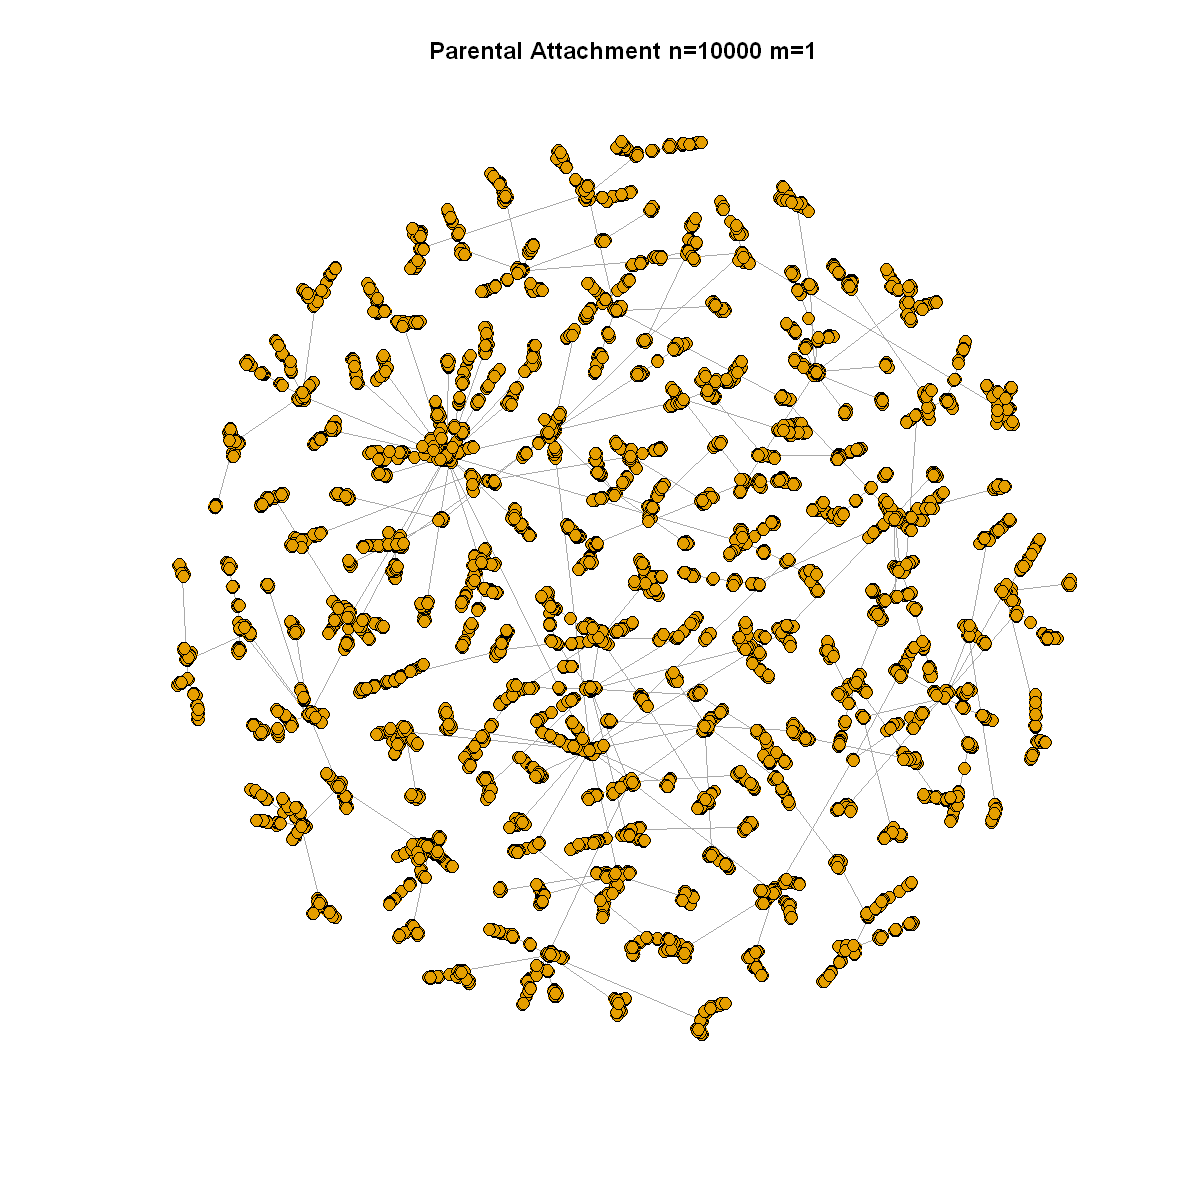

In [111]:
options(repr.plot.width=10, repr.plot.height=10)
plot(g_10000,vertex.size=3,vertex.label=NA,margin=c(0,0,0,0),arrow.size=0)
title(sprintf("Parental Attachment n=%.0f m=%.0f",N,M))

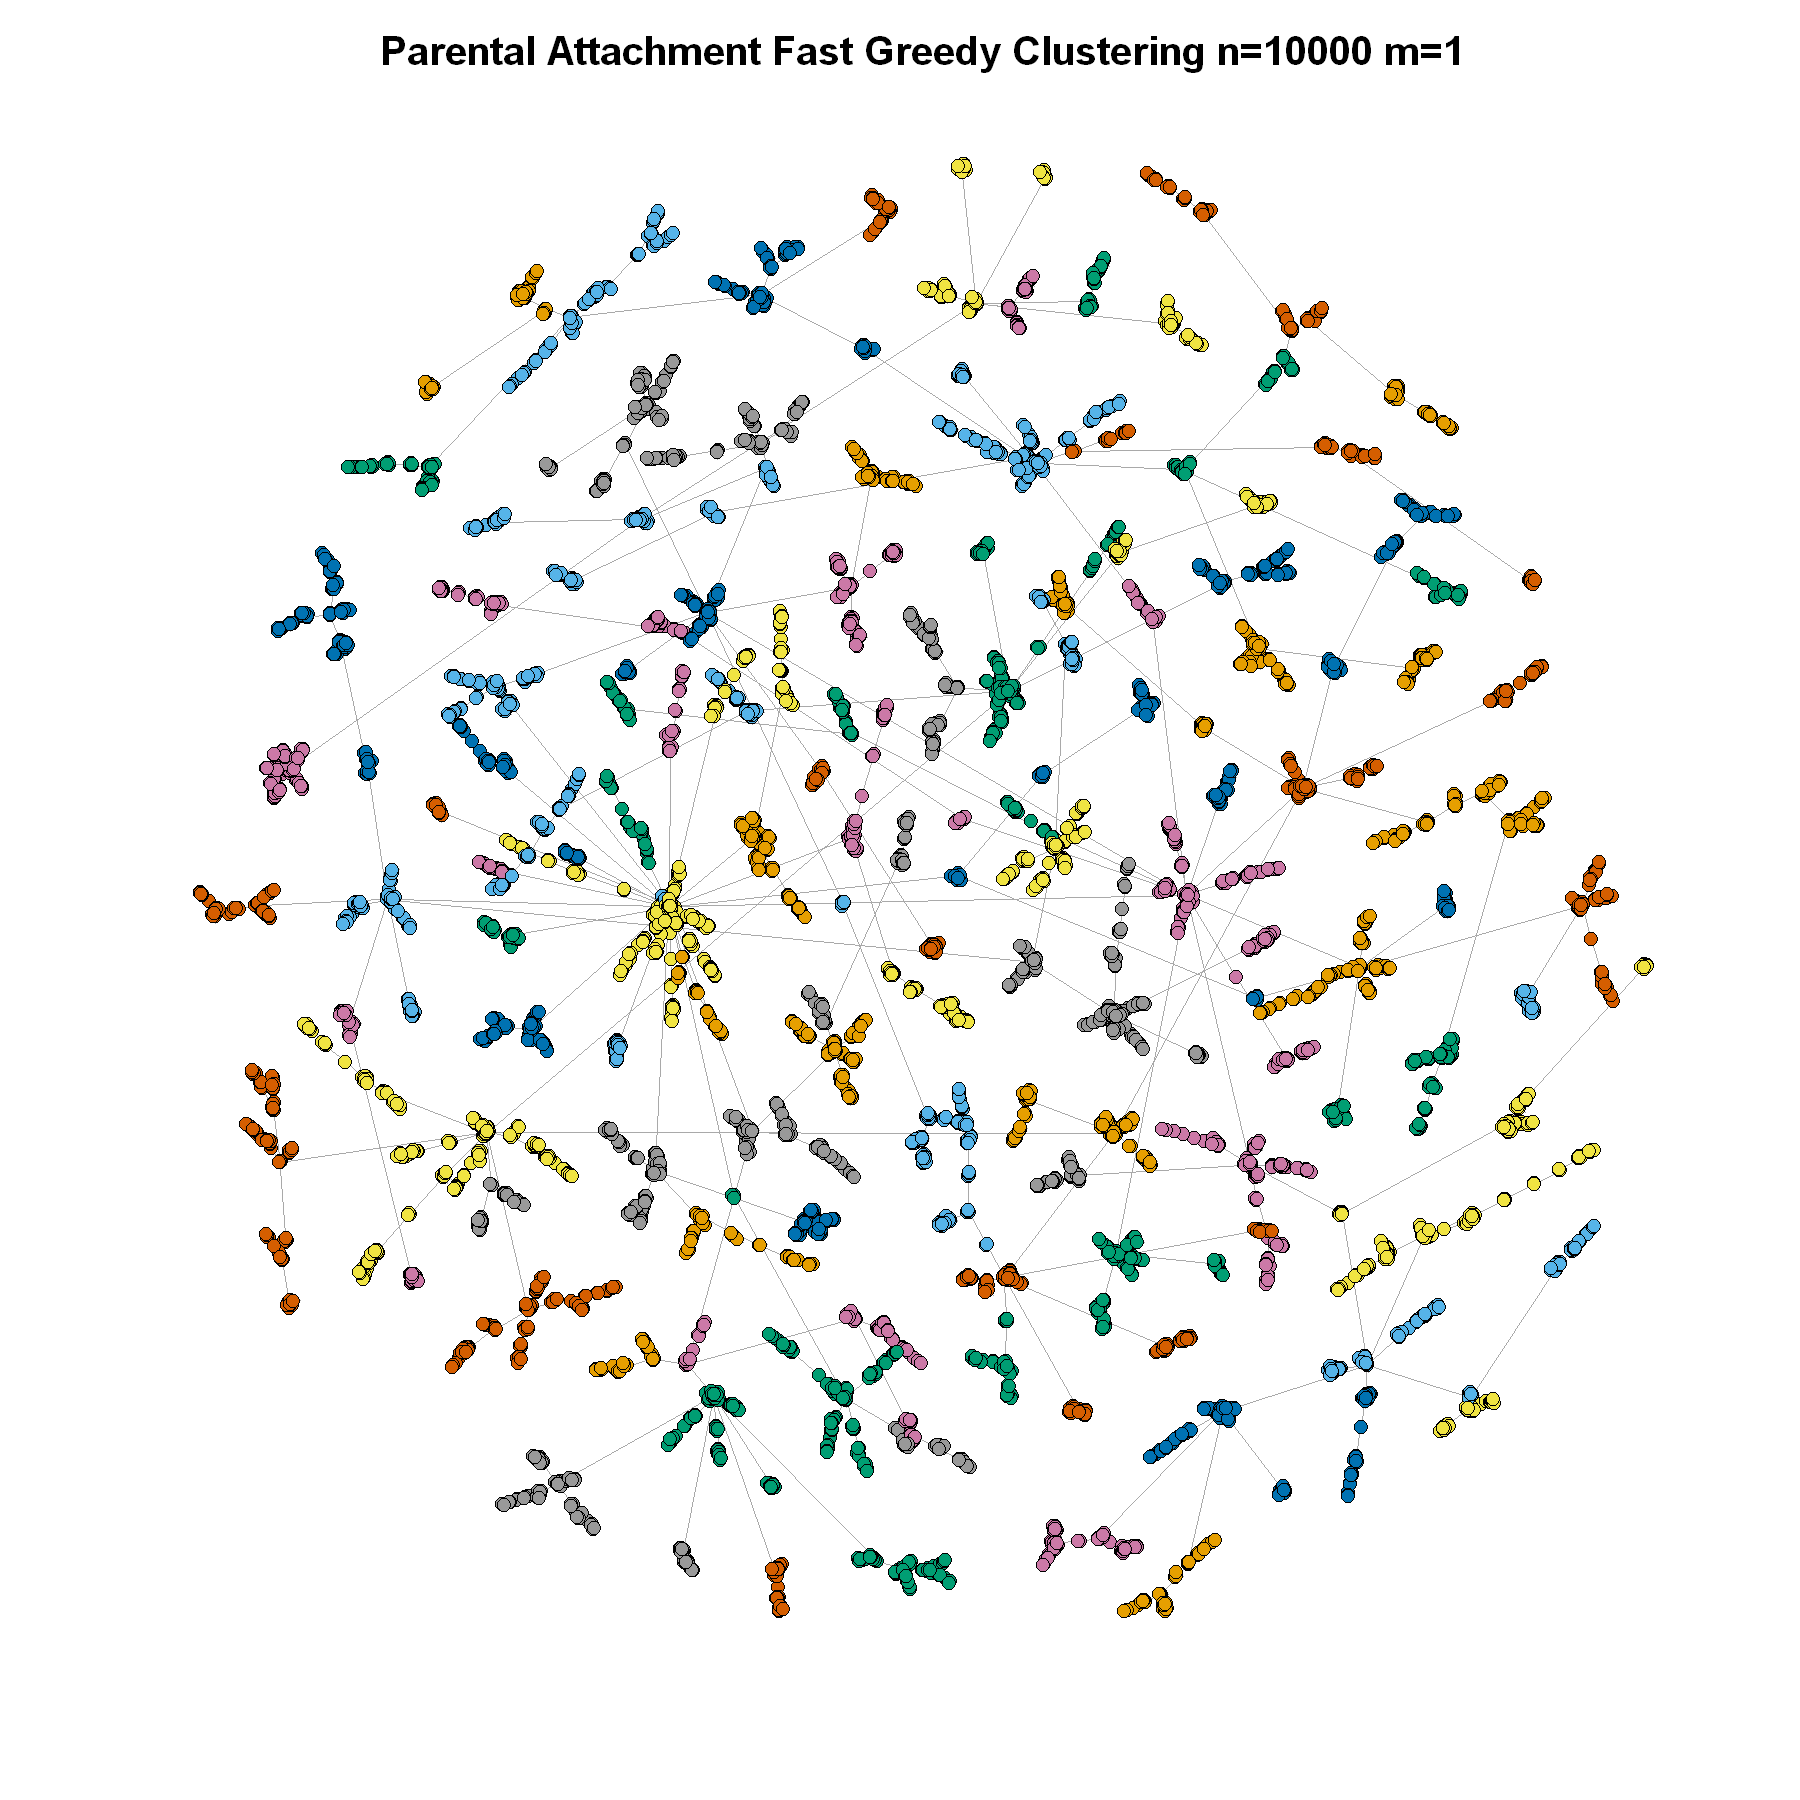

In [115]:
cluster_fg_10000= cluster_fast_greedy(g_10000)
options(repr.plot.width=15, repr.plot.height=15)
plot(g_10000, vertex.color=membership(cluster_fg_10000),vertex.label=NA,vertex.size=2,margin=c(0,0,0,0))
title(sprintf("Parental Attachment Fast Greedy Clustering n=%.0f m=%.0f",N,M),cex.main=2)

In [116]:
print(sprintf("The modularity of the graph is %.4f",modularity(cluster_fg_10000)))

[1] "The modularity of the graph is 0.9780"


### (d) Plot the degree distribution in a log-log scale for both n = 1000; 10000, then estimate the slope of the plot using linear regression

In [241]:
library(scales)

In [258]:
degree_1000 <- degree.distribution(g_1000)
degree_10000 <- degree.distribution(g_10000)

In [259]:
dg_1000_idx = is.infinite(log(degree_1000))
dg_10000_idx = is.infinite(log(degree_10000))

In [260]:
degree_1000_df = data.frame(degree_1000=seq_along(degree_1000)-1,
                       degree_1000_p = degree_1000)[!dg_1000_idx,]
degree_10000_df = data.frame(degree_10000= seq_along(degree_10000)-1,
                       degree_10000_p = degree_10000)[!dg_10000_idx,]

In [261]:
log_degree_1000_df = log(degree_1000_df)
log_degree_10000_df = log(degree_10000_df)

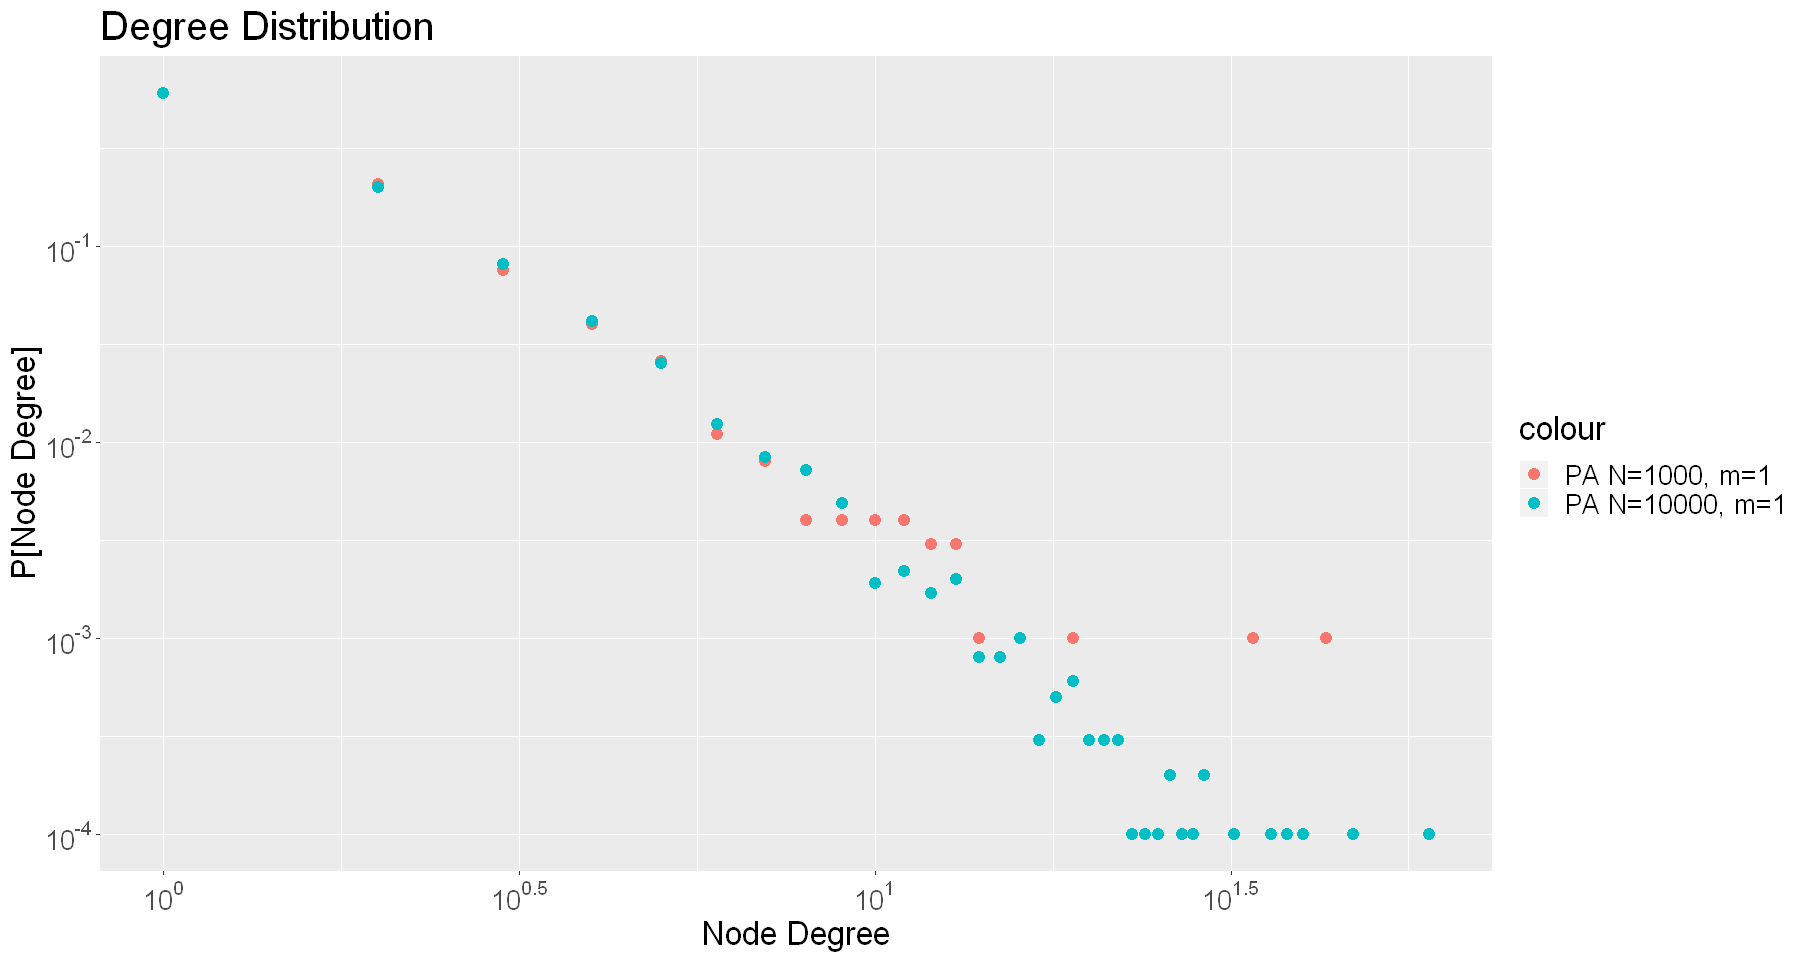

In [262]:
scatterplot <- ggplot() +
geom_point(aes(x=degree_1000,y=degree_1000_p,colour='PA N=1000, m=1'),data=degree_1000_df,size=3) +
geom_point(aes(x=degree_10000,y=degree_10000_p,colour='PA N=10000, m=1'),data=degree_10000_df,size=3) + 
scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
              labels = trans_format("log10", math_format(10^.x))) +
scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
              labels = trans_format("log10", math_format(10^.x))) +
ylab("P[Node Degree]") + xlab("Node Degree") + labs(title="Degree Distribution") +
theme(text = element_text(size=20))

options(repr.plot.width=15, repr.plot.height=8)
plot(scatterplot)

In [263]:
lm(degree_1000_p~degree_1000, log_degree_1000_df)


Call:
lm(formula = degree_1000_p ~ degree_1000, data = log_degree_1000_df)

Coefficients:
(Intercept)  degree_1000  
     -0.787       -1.943  


In [278]:
lm(degree_10000_p~degree_10000, log_degree_10000_df)


Call:
lm(formula = degree_10000_p ~ degree_10000, data = log_degree_10000_df)

Coefficients:
 (Intercept)  degree_10000  
     0.04325      -2.61147  


### (d) In the two networks generated in 2(d), perform the following: Randomly pick a node i, and then randomly pick a neighbor j of that node. Plot the degree distribution of nodes j that are picked with this process, in the log-log scale. Is the distribution linear in the log-log scale? If so, what is the slope? How does this differ from the node degree distribution?

In [314]:
sampled_nodes = sample(V(g_1000),1)

In [ ]:
for (node in sampled_nodes){
    sample_neighbor = sample(neighbors(g_1000,node),1)
    degree(g_1000,sample_neighbor)
}

In [307]:
sample_neighbor = sample(neighbors(g_1000,v1),1)

In [315]:
degree(g_1000,sample_neighbor)

[1] 9